This is a preliminar analysis on the issues colected from SonarQube, on top of the Akka and NLog repositories

In [73]:
import json
import pandas as pd

In [102]:
def load_project_names():
    file_path = 'sonar-issues-miner/resources/java_project_list.json'
    with open(file_path) as f:
        projects_json = json.load(f)
        return list(pd.json_normalize(projects_json)['projectName'])

project_names = load_project_names()

In [186]:
def get_project_issues(project_name):
    file_path = f'sonar-issues-miner/resources/open-issues/{project_name}_issues.json'
    
    with open(file_path) as f:
        d = json.load(f)[0]
        print(f"{file_path} has {d['total']} issues")
        return d['issues']

nlog = get_project_issues('NLog')

sonar-issues-miner/resources/open-issues/NLog_issues.json has 299 issues


In [187]:
def load_issues_per_project():
    issues_per_project = {}
    for project in project_names:
        issues_per_project[project] = pd.json_normalize(get_project_issues(project))
    return issues_per_project

issues_per_project = load_issues_per_project()

sonar-issues-miner/resources/open-issues/Akka.net_issues.json has 3248 issues
sonar-issues-miner/resources/open-issues/NLog_issues.json has 299 issues


<Axes: title={'center': 'Issues by Severity'}, xlabel='project'>

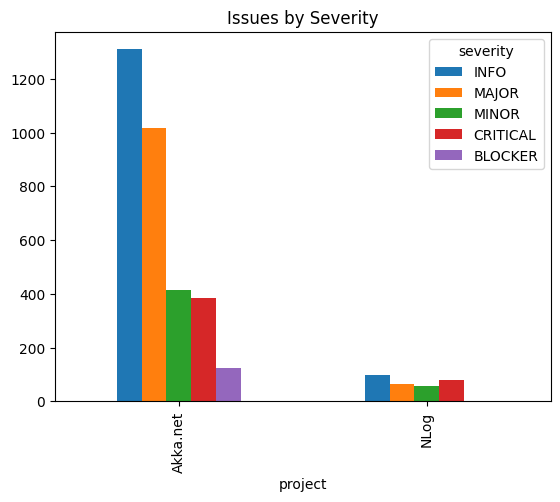

In [190]:
def get_issue_property(issues_per_project, property):
    severity = []
    for project, issues in issues_per_project.items():
        issues_severity = issues[property].value_counts()
        df_val_counts = pd.DataFrame(issues_severity).T
        df_val_counts['project'] = project
        df_val_counts.set_index('project', inplace=True)
        severity.append(df_val_counts)
    return pd.concat(severity)


get_issue_property(issues_per_project, 'severity').plot.bar(title="Issues by Severity")

<Axes: title={'center': 'Issues by Type'}, xlabel='project'>

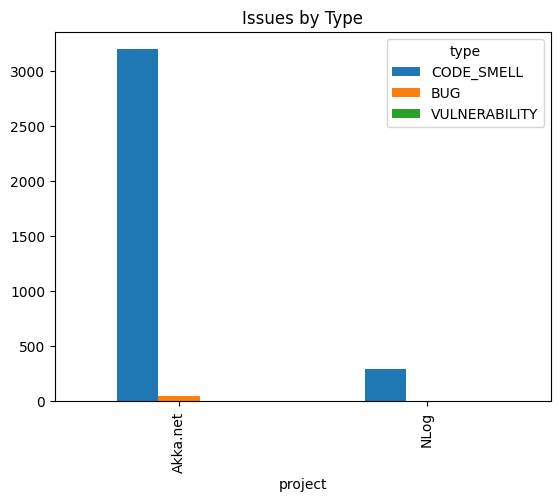

In [191]:
get_issue_property(issues_per_project, "type").plot.bar(title="Issues by Type")

In [196]:
get_issue_property(issues_per_project, 'message').fillna(0).T.to_csv('issue_messages.csv', sep='|')

In [245]:
get_issue_property(issues_per_project, 'message').fillna(0).T.sort_values(by="NLog", ascending=False).to_csv('issue_messages_nlog_sorted.csv', sep='|')

<Axes: title={'center': 'Issues per Rule'}, xlabel='rule'>

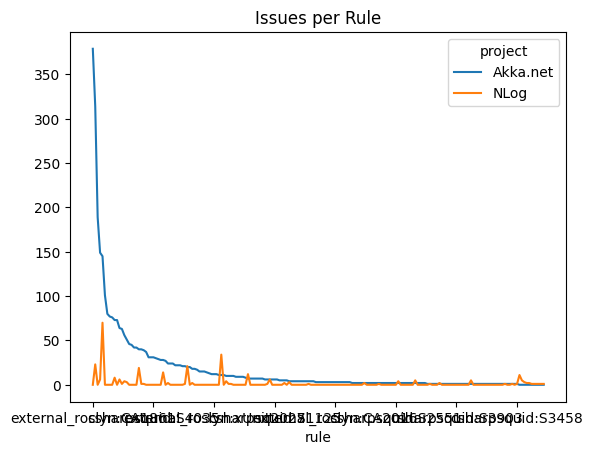

In [200]:
get_issue_property(issues_per_project, 'rule').fillna(0).T.plot(title="Issues per Rule")#.to_csv('issue_messages.csv', sep=';')

In [223]:
rules = get_issue_property(issues_per_project, 'rule').fillna(0).T
rules

project,Akka.net,NLog
rule,,
external_roslyn:CA1861,379.0,0.0
external_roslyn:CA1822,314.0,23.0
csharpsquid:S2436,189.0,0.0
csharpsquid:S1135,149.0,6.0
csharpsquid:S3776,145.0,70.0
...,...,...
csharpsquid:S3904,0.0,1.0
external_roslyn:CA1830,0.0,1.0
csharpsquid:S4220,0.0,1.0


In [235]:
def cumulative_sum(df, property):
    df = df.sort_values(by=property,ascending=False)
    df[f"{property}_cumsum"] = df[property].cumsum()/df[property].sum()*100
    return df

def get_head_percentil_row(df, percentil=20):
    n = len(df)
    ith = percentil*n//100
    return df.iloc[[ith]]

get_head_percentil_row(cumulative_sum(rules, 'Akka.net'), 20)


project,Akka.net,NLog,Akka.net_cumsum
rule,,,
external_roslyn:CS8632,21.0,0.0,80.511084


In [236]:
get_head_percentil_row(cumulative_sum(rules, 'NLog'), 20)

project,Akka.net,NLog,NLog_cumsum
rule,,,
csharpsquid:S2292,1.0,1.0,96.989967


In [238]:
rules["total"] = rules["NLog"] + rules["Akka.net"]
rules

project,Akka.net,NLog,total
rule,,,
external_roslyn:CA1861,379.0,0.0,379.0
external_roslyn:CA1822,314.0,23.0,337.0
csharpsquid:S2436,189.0,0.0,189.0
csharpsquid:S1135,149.0,6.0,155.0
csharpsquid:S3776,145.0,70.0,215.0
...,...,...,...
csharpsquid:S3904,0.0,1.0,1.0
external_roslyn:CA1830,0.0,1.0,1.0
csharpsquid:S4220,0.0,1.0,1.0


In [239]:
get_head_percentil_row(cumulative_sum(rules, 'total'), 20)

project,Akka.net,NLog,total,total_cumsum
rule,,,,
csharpsquid:S101,21.0,1.0,22.0,79.391035


In [202]:
nlog[0]

{'key': 'AZPNRAzbC1iDw2uqLj5g',
 'rule': 'csharpsquid:S3904',
 'severity': 'CRITICAL',
 'component': 'NLog',
 'project': 'NLog',
 'flows': [],
 'status': 'OPEN',
 'message': "Provide an 'AssemblyVersion' attribute for assembly 'SampleExtensions'.",
 'effort': '2min',
 'debt': '2min',
 'author': '',
 'tags': ['pitfall'],
 'creationDate': '2024-12-15T23:19:21-0300',
 'updateDate': '2024-12-15T23:19:21-0300',
 'type': 'CODE_SMELL',
 'scope': 'MAIN',
 'quickFixAvailable': False,
 'messageFormattings': []}

In [210]:
akaMetrics = json.loads('{"paging":{"pageIndex":1,"pageSize":100,"total":0},"baseComponent":{"key":"Akka.net","name":"Akka.net","qualifier":"TRK","measures":[{"metric":"ncloc","value":"130208"},{"metric":"classes","value":"3327"},{"metric":"sqale_rating","value":"1.0","bestValue":true},{"metric":"reliability_rating","value":"4.0","bestValue":false},{"metric":"security_rating","value":"4.0","bestValue":false},{"metric":"alert_status","value":"OK"},{"metric":"last_commit_date","value":"1733335599000"}]},"components":[]}')
nLogMetrics = json.loads('{"paging":{"pageIndex":1,"pageSize":100,"total":0},"baseComponent":{"key":"NLog","name":"NLog","qualifier":"TRK","measures":[{"metric":"ncloc","value":"46814"},{"metric":"classes","value":"582"},{"metric":"sqale_rating","value":"1.0","bestValue":true},{"metric":"reliability_rating","value":"3.0","bestValue":false},{"metric":"security_rating","value":"1.0","bestValue":true},{"metric":"alert_status","value":"OK"},{"metric":"last_commit_date","value":"1729661575000"}]},"components":[]}')

metrics = [akaMetrics, nLogMetrics]

In [ ]:
for project, issues in issues_per_project.items():
        issues_severity = issues[property].value_counts()
        df_val_counts = pd.DataFrame(issues_severity).T
        df_val_counts['project'] = project
        df_val_counts.set_index('project', inplace=True)
        severity.append(df_val_counts)
    return pd.concat(severity)

In [211]:
metrics

[{'paging': {'pageIndex': 1, 'pageSize': 100, 'total': 0},
  'baseComponent': {'key': 'Akka.net',
   'name': 'Akka.net',
   'qualifier': 'TRK',
   'measures': [{'metric': 'ncloc', 'value': '130208'},
    {'metric': 'classes', 'value': '3327'},
    {'metric': 'sqale_rating', 'value': '1.0', 'bestValue': True},
    {'metric': 'reliability_rating', 'value': '4.0', 'bestValue': False},
    {'metric': 'security_rating', 'value': '4.0', 'bestValue': False},
    {'metric': 'alert_status', 'value': 'OK'},
    {'metric': 'last_commit_date', 'value': '1733335599000'}]},
  'components': []},
 {'paging': {'pageIndex': 1, 'pageSize': 100, 'total': 0},
  'baseComponent': {'key': 'NLog',
   'name': 'NLog',
   'qualifier': 'TRK',
   'measures': [{'metric': 'ncloc', 'value': '46814'},
    {'metric': 'classes', 'value': '582'},
    {'metric': 'sqale_rating', 'value': '1.0', 'bestValue': True},
    {'metric': 'reliability_rating', 'value': '3.0', 'bestValue': False},
    {'metric': 'security_rating', 'va

In [218]:
def parse(metric):
    df = pd.json_normalize(metric['baseComponent']['measures'])
    df['project'] = metric['baseComponent']['name']
    return df.pivot(index='project', columns='metric', values='value')

def parse_project_metrics(metrics):
    result = []
    for project in metrics:
        result.append(parse(project))
    return pd.concat(result)

parse_project_metrics(metrics)


metric,alert_status,classes,last_commit_date,ncloc,reliability_rating,security_rating,sqale_rating
project,,,,,,,
Akka.net,OK,3327,1733335599000,130208,4.0,4.0,1.0
NLog,OK,582,1729661575000,46814,3.0,1.0,1.0
